In [1]:
# Imports
import networkx as nx
import pandas as pd
import numpy as np
import random
import wikipediaapi
import wikipedia
import time
from operator import itemgetter
import matplotlib.pyplot as plt
from scipy import spatial
from gensim.models import Word2Vec
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import spacy
import en_core_web_md # python -m spacy download en_core_web_md
from config import *

wiki_wiki = wikipediaapi.Wikipedia('en')

In [2]:
# Loading data
'''
edge_list = pd.read_csv("small_data.tsv", sep = "\t")
edge_list2 = pd.read_csv("ml-nlp-ai.tsv", sep = "\t")
edge_list3 = pd.read_csv("ml-nlp-ai-ann-dist2.tsv", sep = "\t")
edge_list4 = pd.read_csv("ml-nlp-ai-ann-dist3.tsv", sep = "\t")
edge_list5 = pd.read_csv("ml-nlp-ai-ann-chatbot-dist2.tsv", sep = "\t")
edge_list6 = pd.read_csv("ml-nlp-ai-ann-chatbot-dist3.tsv", sep = "\t")
'''
edge_list = pd.read_csv("ml-nlp-ai-ann-chatbot-ia-dataviz-dist2.tsv", sep = "\t")
edge_list.head()

,source,target,depth
0,intelligent agent,software agent,1
1,intelligent agent,cognitive architecture,1
2,intelligent agent,cognitive radio,1
3,intelligent agent,cybernetics,1
4,intelligent agent,computer science,1


In [3]:
# Building graph
graph = nx.from_pandas_edgelist(edge_list, "source", "target", edge_attr=True)
print("Number of nodes: ", len(graph))

Number of nodes:  1166


# Node to vector representations

Algorithms:
- Deepwalk
- Node2Vec

Nodes appearing in the same context will have similar embeddings. The context is defined as sequences of nodes built by random walks.

Why not just recommend neighboring nodes instead of bothering with embeddings ? The connectedness of the nodes in a graph does not necessarily mean that they are semantically similar. Besides embeddings allow us to do linear algebra on the representations. This is especially useful for queries with multiple keywords.

In [4]:
class Deepwalk():
    """DeepWalk algorithm"""
    
    def __init__(self, graph, walk_length=10, num_walks=5):
        """Inits a Deepwalk instance.
        
        Args:
            graph: graph to embed
            walk_length: number of steps per walk
            num_walks: number of walks per starting node
        """
        
        self.graph = graph
        self.walk_length = walk_length
        self.num_walks = num_walks
        
        self.walks = []

        for node in graph.nodes():
            for i in range(self.num_walks):
                self.walks.append(self.build_walk(node))
        
    def build_walk(self, node, repeat_nodes=True):
    
        walk = [node]
    
        for i in range(self.walk_length-1):
            neighbors = list(self.graph.neighbors(node))
            if not repeat_nodes:
                neighbors = list(set(neighbors)-set(walk))
            if len(neighbors) == 0:
                break
            next_node = random.choice(neighbors)
            walk.append(next_node)
            node = next_node

        return walk
    
    def fit(self, window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20):
        """Train Word2Vec model with skip-gram and negative sampling based on pre-computed walks"""
        return Word2Vec(self.walks, size=size, window=window, 
                        min_count=min_count, sg=sg, hs=hs, negative=negative, iter=iter)

In [5]:
deepwalk = Deepwalk(graph, walk_length=10, num_walks=5)
deepwalk_model = deepwalk.fit(window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20)

In [6]:
node2vec = Node2Vec(graph, walk_length=10, num_walks=5, quiet=True)
node2vec_model = node2vec.fit(window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20)

In [7]:
deepwalk_model.wv.similar_by_word('artificial intelligence')

[('a.i. rising', 0.8536570072174072),
 ('soft computing', 0.8330191373825073),
 ('robotic process automation', 0.8144057393074036),
 ('personality computing', 0.7953453063964844),
 ('glossary of artificial intelligence', 0.748216986656189),
 ('behavioral modeling in computer-aided design', 0.7244319915771484),
 ('glossary of machine vision', 0.7144978046417236),
 ('business process automation', 0.6888904571533203),
 ('comparison of business integration software', 0.6879185438156128),
 ('real-time enterprise', 0.6839792728424072)]

In [8]:
node2vec_model.wv.similar_by_word('artificial intelligence')

[('robotic process automation', 0.8132063746452332),
 ('personality computing', 0.7816567420959473),
 ('a.i. rising', 0.7777826189994812),
 ('soft computing', 0.7758406400680542),
 ('glossary of artificial intelligence', 0.7708931565284729),
 ('glossary of machine vision', 0.7206389904022217),
 ('business process automation', 0.6948916912078857),
 ('comparison of business integration software', 0.6827898025512695),
 ('cognitive model', 0.6776918768882751),
 ('business-driven development', 0.6669925451278687)]

In [9]:
nodes_to_plot = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 
                 'moon landing','space food', 'food systems on space exploration missions', 
                 'meal, ready-to-eat','space law', 'metalaw', 'moon treaty', 
                 'legal aspects of computing','astronaut training', 'reduced-gravity aircraft', 
                 'space adaptation syndrome', 'micro-g environment']

nodes_to_plot = ['machine learning', 'machine learning in bioinformatics', 'one-shot learning',
                 'hyperparameter optimization', 'system identification', 'model selection',
                 'self-tuning', 'artificial intelligence', 'artificial neural network',
                 'artificial neural network', 'intelligent agent', 'data visualization']

In [10]:
def plot_projection(model, nodes, dim=2, projection_method=PCA):
    """Plot the projection of embeddings after applying a dimensionality reduction method."""
    node_vectors = model.wv[nodes]
    projection = projection_method(n_components=dim)
    projections = projection.fit_transform(node_vectors)
    
    plt.figure(figsize=(10,7))
    plt.scatter(projections[:,0], projections[:,1])
    for i, node in enumerate(nodes):
        plt.annotate(node, xy=(projections[i,0], projections[i,1]))
    plt.title("{} over first {} components".format(type(projection).__name__, dim))
    plt.show()

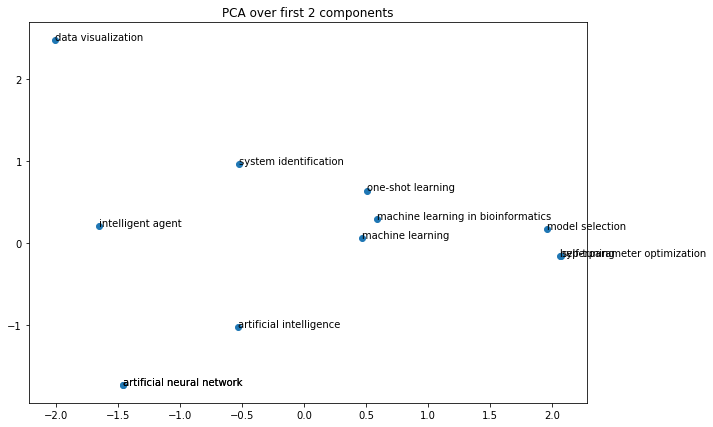

In [11]:
plot_projection(deepwalk_model, nodes_to_plot)

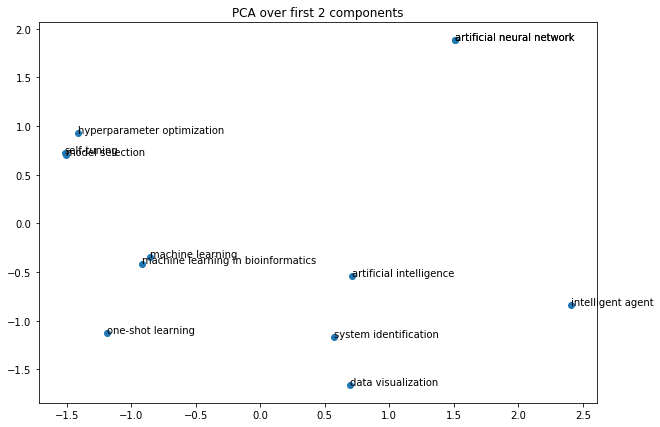

In [12]:
plot_projection(node2vec_model, nodes_to_plot)

In [13]:
def get_url(node):
    return "https://en.wikipedia.org/wiki/" + node.replace(" ", "_")

def OLD_get_url_robust(node):
    "Robust to spelling and lower case/upper case errors"
    return wikipedia.page(node).url

def get_url_robust(node):
    "Robust to spelling and lower case/upper case errors"
    try:
        return wikipedia.page(node).url
    except wikipedia.DisambiguationError as e:
        #s = random.choice(e.options)
        s = e.options[0]
        return wikipedia.page(s).url
    except:
        return "https://en.wikipedia.org/wiki/" + node.replace(" ", "_")

In [14]:
df_node = pd.DataFrame(columns=['name','url', 'keywords'])
df_node['name'] = pd.unique(edge_list.source.append(edge_list.target))

In [15]:
# runs for a while with get_url_robust, about 3s per node * 2k nodes = 1h40 
df_node['url'] = [get_url(name) for name in df_node.name]

### Creation of the keywords lists for the nodes

In [20]:
def get_summary(node, num_chars=1000):
    try:
        return wiki_wiki.page(node).summary[:num_chars]
    except:
        return ''
    
def OLD_get_summary_robust(node, num_chars=1000):
    "Robust to spelling and lower case/upper case errors"
    try:
        return wikipedia.summary(node, chars=num_chars)[:num_chars] # summary may not return exactly num_chars
    except:
        return ''
    
def get_summary_robust(node, num_chars=1000):
    "Robust to spelling and lower case/upper case errors"
    try:
        return wikipedia.summary(node, chars=num_chars)[:num_chars] # summary may not return exactly num_chars
    except wikipedia.DisambiguationError as e:
        s = random.choice(e.options)
        return wikipedia.summary(s, chars=num_chars)[:num_chars]
    except:
        return ''

In [16]:
import re
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def pre_process(text):
    text=text.lower()
    text=re.sub("</?.*?>"," <> ",text)
    text=re.sub("(\\d|\\W)+"," ",text)
    return text

def get_stop_words(stop_file_path):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

In [17]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_keywords(idx):

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([docs[idx]]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords

In [18]:
print(len(df_node))

1166


In [23]:
#load a set of stop words
stopwords=get_stop_words("stopwords.txt")

#get the text column 
#docs=df_idf['text'].tolist()
counter = 0
docs = []

# /!\ remove [:10] and put save to True whenever you want to create the pickle for summaries


for name in df_node['name'][:10]:
    print(counter)
    counter += 1
    docs.append(pre_process(get_summary_robust(name)))

save = False
if save:
    with open('ml-nlp-ai-ann-chatbot-ia-dataviz-dist2_summaries.pickle', 'wb') as handle:
        pickle.dump(docs, handle)
else:
    with open('ml-nlp-ai-ann-chatbot-ia-dataviz-dist2_summaries.pickle', 'rb') as handle:
        docs = pickle.load(handle)

#create a vocabulary of words, 
#ignore words that appear in 85% of documents, 
#eliminate stop words
cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
word_count_vector=cv.fit_transform(docs)
word_count_vector.shape

0
1
2
3
4
5
6
7
8
9


(10, 497)

In [ ]:
# potentially limit vocabulary size to 10k
cv=CountVectorizer(max_df=0.85,stop_words=stopwords,max_features=10000)
word_count_vector=cv.fit_transform(docs)
word_count_vector.shape

In [31]:
list(cv.vocabulary_.keys())[:10], list(cv.get_feature_names())[20:25]

(['artificial',
  'intelligence',
  'intelligent',
  'agent',
  'ia',
  'refers',
  'autonomous',
  'entity',
  'acts',
  'directing'],
 ['agents', 'ai', 'aia', 'alexa', 'algorithm'])

In [25]:
# TF-IDF transformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [27]:
# you only needs to do this once
feature_names=cv.get_feature_names()

In [45]:
# Toy example
get_keywords(0)

{'intelligent': 0.583,
 'agents': 0.388,
 'agent': 0.222,
 'autonomous': 0.174,
 'abstract': 0.174,
 'may': 0.148,
 'goals': 0.148,
 'considered': 0.129,
 'computer': 0.115,
 'systems': 0.093}

In [30]:
# adding keywords to df_node
df_node['keywords'] = [get_keywords(idx) for idx in range(len(df_node))]

IndexError: list index out of range

In [ ]:
df_node.head()

In [ ]:
df_node.to_csv(DF_NODE_FILENAME)

In [ ]:
df_edge = pd.DataFrame(columns=['source','target'])
df_edge['source'] = [df_node[df_node.name==name].index.values[0] for name in edge_list.source]
df_edge['target'] = [df_node[df_node.name==name].index.values[0] for name in edge_list.target]
df_edge.to_csv(DF_EDGE_FILENAME)

In [ ]:
df_edge.head()

In [ ]:
node2vec_model.save(NODE2VEC_FILENAME)

# Combining text representations and graph geometry

- Obtain representations of summaries as word2vec or bert embeddings
- Perform walks and average embeddings

## Scalability limitations

- We would need a lot of computational resources for parsing the text and learning word embeddings from all these summaries. However one can use pre-trained embeddings to fix this issue.

In [ ]:
import torch
from transformers import *
from spectral_clustering import *

# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
nlp = en_core_web_md.load()

walks = node2vec.walks

In [ ]:
def bert_embedding(summary):
    "Encode text using Bert model."
    input_ids = torch.tensor([tokenizer.encode(summary, add_special_tokens=True)])  # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples
        last_hidden_states = last_hidden_states.squeeze().mean(dim=0)
    return last_hidden_states.numpy()

In [ ]:
def get_weighted_walk_of_embeddings(walk, embeddings_dict, source_weight=0.75):
    "Given a source embedding and a walk of embeddings, returns the weighted average of embeddings."
    walk_weight = (1-source_weight)/(len(walk)-1)
    bert_embeddings = [embeddings_dict[node] for node in walk]
    return source_weight*bert_embeddings[0] + walk_weight*sum(bert_embeddings[1:])

In [ ]:
def compute_similarities(summary, corpus, top_n=10):
    """Given an embedding and a corpus, returns the closest k embeddings."""
    similarities = {k:(1 - spatial.distance.cosine(summary, v))for k, v in corpus.items()}
    similarities = dict(sorted(similarities.items(), key = itemgetter(1), reverse = True)[:top_n])
    return similarities

In [ ]:
# Scrapping summary for each article
# ~25 sc per 100 articles. Not very efficient since we make requests sequentially and not in batch
#t = time.time()
summaries = [get_summary(node, num_chars=280) for node in graph.nodes()]
#print("Scrapped summaries in {0:.0f} seconds".format(time.time()-t))

In [ ]:
mean_embeddings = [nlp(summary).vector for summary in summaries]
embeddings_dict = dict(zip(list(graph.nodes()), mean_embeddings))

In [ ]:
walk_embeddings_dict = {k:[] for k in embeddings_dict.keys()}

for walk in walks:
    walk_embeddings_dict[walk[0]].append(get_weighted_walk_of_embeddings(walk, embeddings_dict, source_weight=0.75))

walk_averaged_embeddings_dict = {k:sum(v)/len(v) for k, v in walk_embeddings_dict.items()}

In [ ]:
compute_similarities(walk_averaged_embeddings_dict['space research'], walk_averaged_embeddings_dict)

In [ ]:
mean_embeddings_bert = [bert_embedding(summary) for summary in summaries]
embeddings_dict_bert = dict(zip(list(graph.nodes()), mean_embeddings_bert))

In [ ]:
walk_embeddings_dict_bert = {k:[] for k in embeddings_dict_bert.keys()}

for walk in walks:
    walk_embeddings_dict_bert[walk[0]].append(get_weighted_walk_of_embeddings(walk, embeddings_dict_bert, source_weight=0.75))

walk_averaged_embeddings_dict_bert = {k:sum(v)/len(v) for k, v in walk_embeddings_dict_bert.items()}

In [ ]:
compute_similarities(walk_averaged_embeddings_dict_bert['space research'], walk_averaged_embeddings_dict_bert)

In [ ]:
#Reindex according to the dataframe
mean_embeddings_bert_array = np.zeros((len(mean_embeddings_bert),len(mean_embeddings_bert[0])))
for k,v in walk_averaged_embeddings_dict_bert.items():
    idx = df_node[df_node.name == k].index.values[0]
    mean_embeddings_bert_array[idx] = v
np.save(BERT_MEAN_FILENAME,mean_embeddings_bert_array)

In [ ]:
#Reindex according to the dataframe
embeddings_bert_array = np.zeros((len(mean_embeddings_bert),len(mean_embeddings_bert[0])))
for k,v in embeddings_dict_bert.items():
    idx = df_node[df_node.name == k].index.values[0]
    embeddings_bert_array[idx] = v

In [ ]:
#TODO tune param
proj = laplacian_eigenmaps(embeddings_bert_array, dim=len(mean_embeddings_bert[0]), sigma=8, epsilon=0.01, normalize=True)
np.save(SPECTRAL_CLUSTERING_FILENAME,proj)